# Classification of Graphs uning Convolutional Neural Network

## Fetch Data

mount google drive to fetch the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


checking if the csv file exists

In [3]:
 import os
dir_path = "/content/drive/MyDrive/charts"
file_name = "train_val.csv"
file_path = os.path.join(dir_path, file_name)
print(os.path.exists(file_path))

True


using panda read the csv file as dataframe

In [4]:
import pandas as pd
df = pd.read_csv(file_path)
df.head()

,image_index,type
0,0,vbar_categorical
1,1,vbar_categorical
2,2,vbar_categorical
3,3,vbar_categorical
4,4,vbar_categorical


check the different label names that are given and also to count the number of labels

In [5]:
df.type.unique()

array(['vbar_categorical', 'hbar_categorical', 'line', 'pie', 'dot_line'],
      dtype=object)

list all the files that are available in the training dir

In [6]:
train_dir = os.path.join(dir_path, "train_val")
train_paths = os.listdir(train_dir)
print(len(train_paths))

1000


Reading all the data

In [7]:
import numpy as np
import cv2
def sort_data(dir, data, df):
    images = []
    labels = []
    for i in range(len(data)):
        img = cv2.imread(os.path.join(dir, data[i])) # read the image from the train_val dir
        index = int(data[i].split(".")[0])           # splits the filename with dot separator to get the file name and not the extension 
        label = df.loc[index, 'type']                # find the associated label from the dataframe
        labels.append(label)
        images.append(img)
    return np.array(images), np.array(labels)

X_train, Y_train = sort_data(train_dir, train_paths, df)

# checking the number of samples
print(X_train.shape)
print(Y_train.shape)

(1000, 128, 128, 3)
(1000,)


checking the max and min value to see if they are appropriate range

In [8]:
print(np.amax(X_train[800]))
print(np.amin(X_train[800]))

255
0


split the data in to training and validation

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(
    X_train, 
    Y_train, 
    test_size=200, # no. of samples in validation set
    shuffle=True,
    random_state=42,
    stratify=Y_train
)

print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(800, 128, 128, 3)
(800,)
(200, 128, 128, 3)
(200,)


In [10]:
print(np.amax(x_validation[150]))
print(np.amin(x_validation[150]))

255
148


check whether the data is equally distributed among the all the categories

In [11]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_validation, return_counts=True))

(array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype='<U16'), array([160, 160, 160, 160, 160]))
(array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype='<U16'), array([40, 40, 40, 40, 40]))


Integer encoding

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_validation_enc = le.transform(y_validation)

print(np.unique(y_train_enc, return_counts=True))
print(np.unique(y_validation_enc, return_counts=True))

(array([0, 1, 2, 3, 4]), array([160, 160, 160, 160, 160]))
(array([0, 1, 2, 3, 4]), array([40, 40, 40, 40, 40]))


### Visualize random training samples along with labels and associated encoding

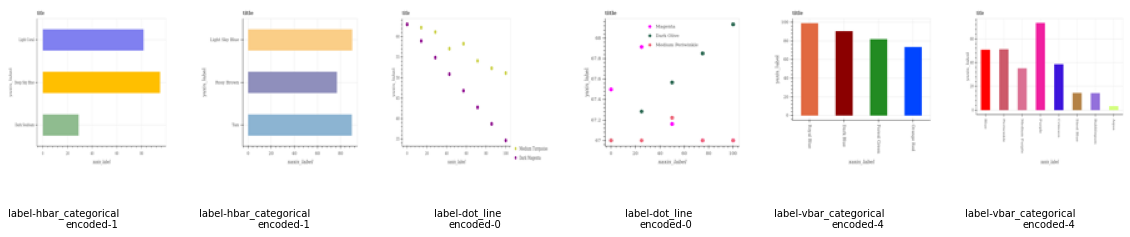

In [13]:
import matplotlib.pyplot as plt
import cv2
n = np.random.randint(0, 800, 6)
plt.figure(figsize=(20, 4))
for i in range(1, len(n)+1): 
    ax = plt.subplot(1, len(n), i)
    img = x_train[n[i-1]]
    plt.imshow(img)
    # plt.title(Y_train[n[i-1]])
    ax.text(0.7, -0.4, "label-{0}\nencoded-{1}".format(y_train[n[i-1]], y_train_enc[n[i-1]]),
    verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, fontsize=10)
    plt.axis("off")
plt.show()

## Model Training

**A simple CNN model was made with just 2 convolution layers**

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(128, 128, 3))
x = tf.keras.layers.Conv2D(filters=64, kernel_size=10)(inputs)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=5)(x)
x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(5)(x)

model1 = keras.Model(inputs, out)
model1.summary()

checkpoint_filepath = '/content/drive/MyDrive/charts/model/cnn/cnn_epoch-{epoch:02d}_val_loss-{val_loss:.4f}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_loss",
    mode="auto",
    save_best_only=True)

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history1 = model1.fit(x_train, y_train_enc, batch_size=16,
                      validation_data=(x_validation, y_validation_enc),
                      epochs=50,
                      callbacks=[model_checkpoint_callback])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 119, 119, 64)      19264     
                                                                 
 conv2d_1 (Conv2D)           (None, 115, 115, 32)      51232     
                                                                 
 flatten (Flatten)           (None, 423200)            0         
                                                                 
 dense (Dense)               (None, 5)                 2116005   
                                                                 
Total params: 2,186,501
Trainable params: 2,186,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] -

In [15]:
history1.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

### Plot training and validation loss and accuracy

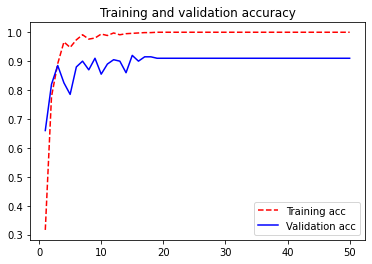

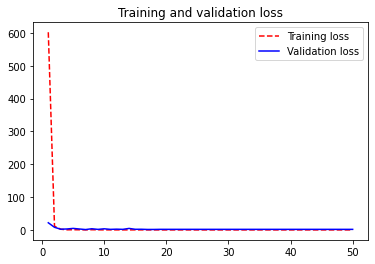

In [16]:
def plot_accuracy_and_loss(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, '--r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_accuracy_and_loss(history1)

enum class was to help understand the predictions after training

### predictions on the test data

In [18]:
test_dir = os.path.join(dir_path,"test")
test_imgs = os.listdir(test_dir)
print(len(test_imgs))

50


images from test dataset are read to see the predictions on them

In [19]:
x_test = []
for img in test_imgs:
    im = cv2.imread(os.path.join(test_dir, img))
    x_test.append(im)
x_test = np.array(x_test)

In [20]:
print(np.amax(x_test[10]))
print(np.amin(x_test[10]))

255
21


Enum class is used to see categorical name associated with predicted value

In [21]:
from enum import Enum
class Number(Enum):
    dot_line = 0
    hbar = 1
    line = 2
    pie = 3
    vbar = 4

Loading the best model

In [23]:
model1 = tf.keras.models.load_model("/content/drive/MyDrive/charts/model/cnn/cnn_epoch-07_val_loss-1.1305")

plotting the predictions using the best model

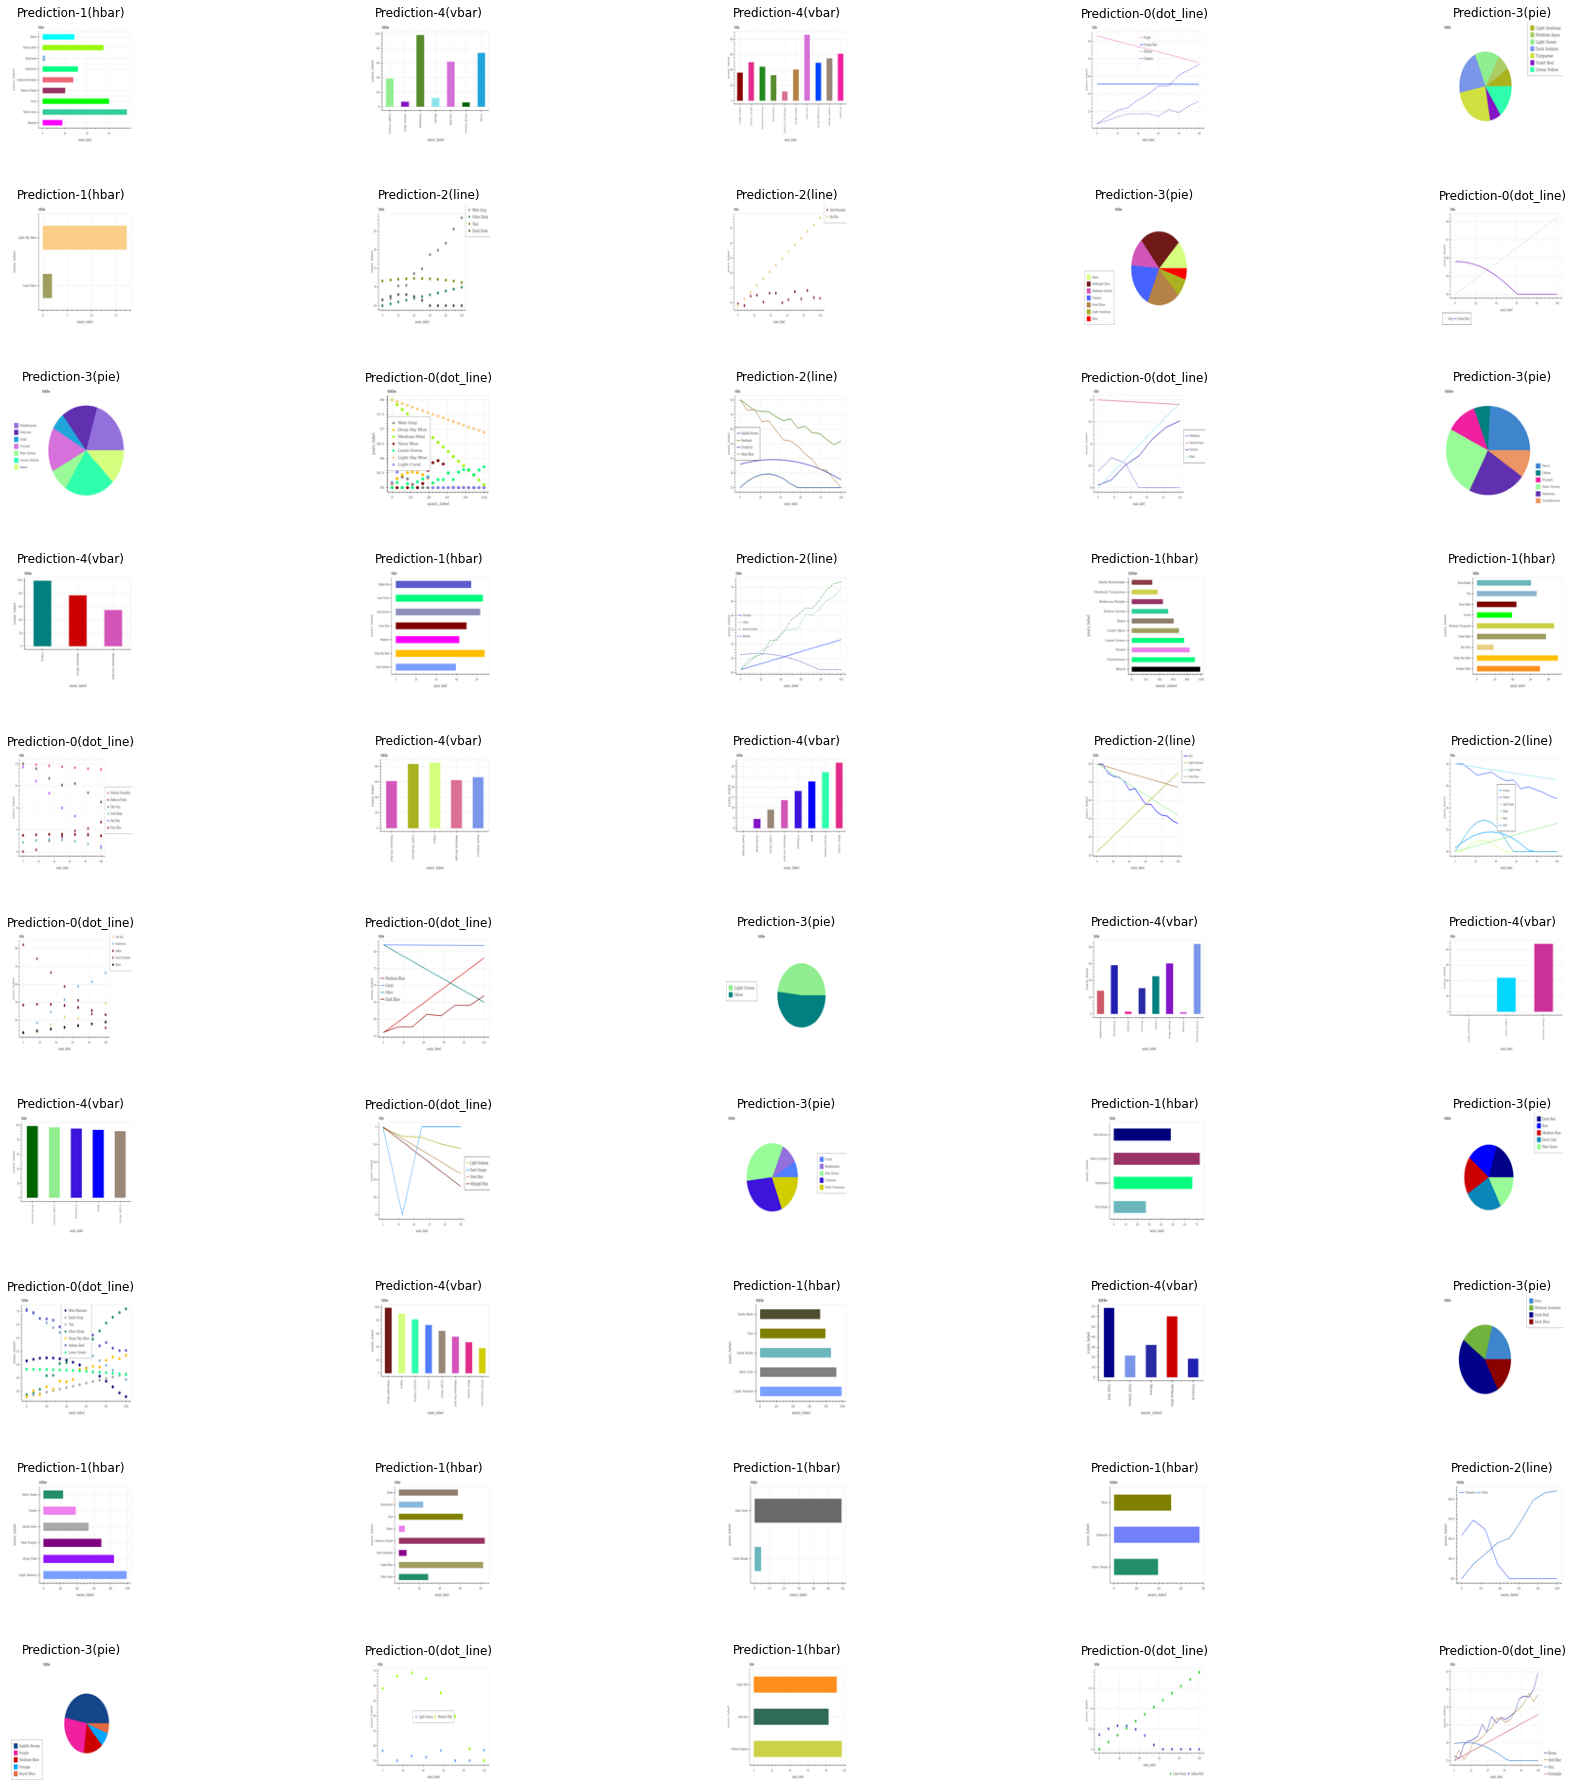

In [45]:
import numpy as np
prediction = model1.predict(x_test)


fig, ax = plt.subplots(10, 5, figsize=(25,25))
fig.tight_layout(h_pad=4)
idx = 0
for i in range(0, 10):
    for j in range(0, 5):

        prediction_label = np.argmax(prediction[idx])
        ax[i][j].title.set_text('Prediction-{0}({1})'.format(prediction_label, Number(prediction_label).name))
        image = x_test[idx]
        ax[i][j].imshow(image)
        ax[i][j].axis("off")
        idx += 1 

plt.savefig(os.path.join(dir_path,"images/cnn/prediction.png"), bbox_inches='tight')
plt.show()

From the above observation it was spotted that some of the line graph could be confusing.

### model performance on training and validation set

In [25]:
train_loss, train_acc = model1.evaluate(x_train, y_train_enc)
print('Accuracy:', train_acc)
print('Loss: ', train_loss)

25/25 [==============================] - 1s 18ms/step - loss: 0.0612 - sparse_categorical_accuracy: 0.9975
Accuracy: 0.9975000023841858
Loss:  0.06116577237844467


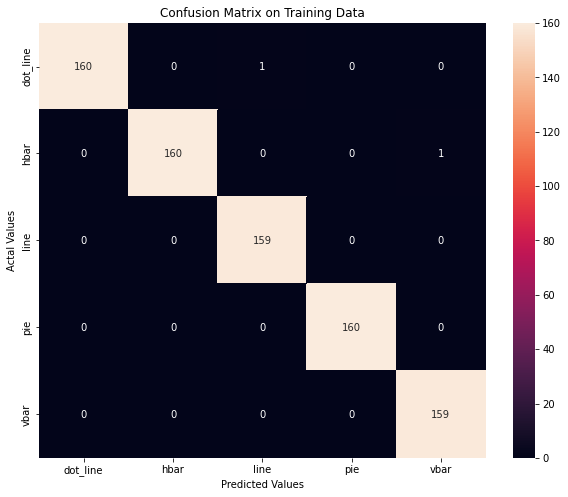

In [26]:
prediction = model1.predict(x_train)
y_pred = [np.argmax(p) for p in prediction]

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, y_train_enc)

cm_df = pd.DataFrame(cm,
                     index = ['dot_line','hbar','line', 'pie', 'vbar'], 
                     columns = ['dot_line','hbar','line', 'pie', 'vbar'])

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix on Training Data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig(os.path.join(dir_path,"images/cnn/train-confusion.png"), bbox_inches='tight')
plt.show()

Evaluation on Validation data


In [27]:
val_loss, val_acc = model1.evaluate(x_validation, y_validation_enc)
print('Accuracy:', val_acc)
print('Loss: ', val_loss)

7/7 [==============================] - 0s 20ms/step - loss: 1.1307 - sparse_categorical_accuracy: 0.9000
Accuracy: 0.8999999761581421
Loss:  1.1307235956192017


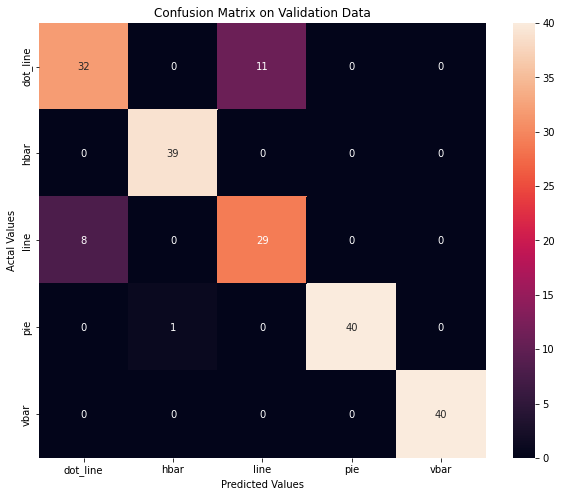

In [28]:
prediction = model1.predict(x_validation)
y_pred = [np.argmax(p) for p in prediction]
cm = confusion_matrix(y_pred, y_validation_enc)

cm_df = pd.DataFrame(cm,
                     index = ['dot_line','hbar','line', 'pie', 'vbar'], 
                     columns = ['dot_line','hbar','line', 'pie', 'vbar'])

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix on Validation Data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig(os.path.join(dir_path,"images/cnn/val-confusion.png"), bbox_inches='tight')
plt.show()

**Upon evaluating the model on both the training and validation set it can be seen that the model is having difficulty in predicting dot_line and line**

## Check which samples from validation set were misclassified

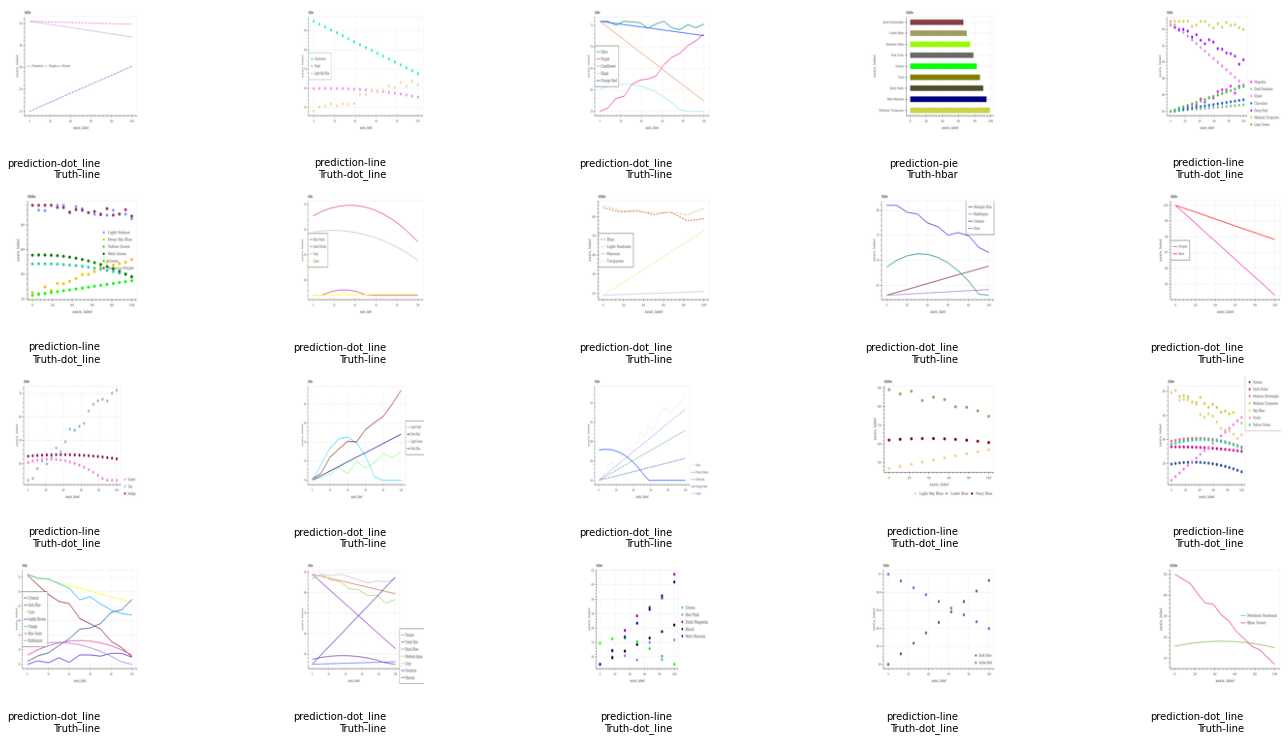

In [44]:
prediction = model1.predict(x_validation)
y_pred = [np.argmax(p) for p in prediction]

indexs = [i for i in range(len(y_pred)) if y_pred[i]!=y_validation_enc[i]]


fig, ax = plt.subplots(4, 5, figsize=(20,10))
fig.tight_layout(h_pad=4)
idx = 0
for i in range(0, 4):
    for j in range(0, 5):

        prediction_label = np.argmax(prediction[indexs[idx]])
        # ax[i][j].title.set_text('Prediction-{0}({1})'.format(prediction_label, Number(prediction_label).name))
        ax[i][j].text(0.7, -0.4, "prediction-{0}\nTruth-{1}".format(Number(prediction_label).name, Number(y_validation_enc[indexs[idx]]).name),
          verticalalignment='bottom', horizontalalignment='right',
          transform=ax[i][j].transAxes, fontsize=10)
        image = x_validation[indexs[idx]]
        ax[i][j].imshow(image)
        ax[i][j].axis("off")
        idx += 1 

plt.savefig(os.path.join(dir_path,"images/cnn/wrong-Valprediction.png"), bbox_inches='tight')
plt.show()

### Visualizing Training data especially dot_lines and line

#### The dot_line graphs and line graphs are plotted since the model wrongly classifies each.

dataframe df2 has only image_index of type 'dot_line'

In [ ]:
df2 = df.copy()
df2 =df2[df2['type']=='dot_line']
print(df2.head())

     image_index      type
800          800  dot_line
801          801  dot_line
802          802  dot_line
803          803  dot_line
804          804  dot_line


dataframe df3 has only image_index of type 'line'

In [ ]:
df3 = df.copy()
df3 = df3[df3['type']=='line']
print(df3.head())

     image_index  type
400          400  line
401          401  line
402          402  line
403          403  line
404          404  line


image index were extracted to a list

In [ ]:
all_lines = df3['image_index'].tolist()
print(len(all_lines))
all_dot_lines = df2['image_index'].tolist()
print(len(all_dot_lines))

200
200


function to read the data and labels

In [ ]:
def read_data(dir, data, df):
    images = []
    labels = []
    for d in data:
        im = cv2.imread(os.path.join(dir, str(d)+".png"))
        label = df.loc[d, 'type']
        images.append(im)
        labels.append(label)

    return np.array(images), np.array(labels)

x_lines, y_lines = read_data(train_dir, all_lines, df3)
print(x_lines.shape)
print(y_lines.shape)

(200, 128, 128, 3)
(200,)


random line graphs were plotted to look for details

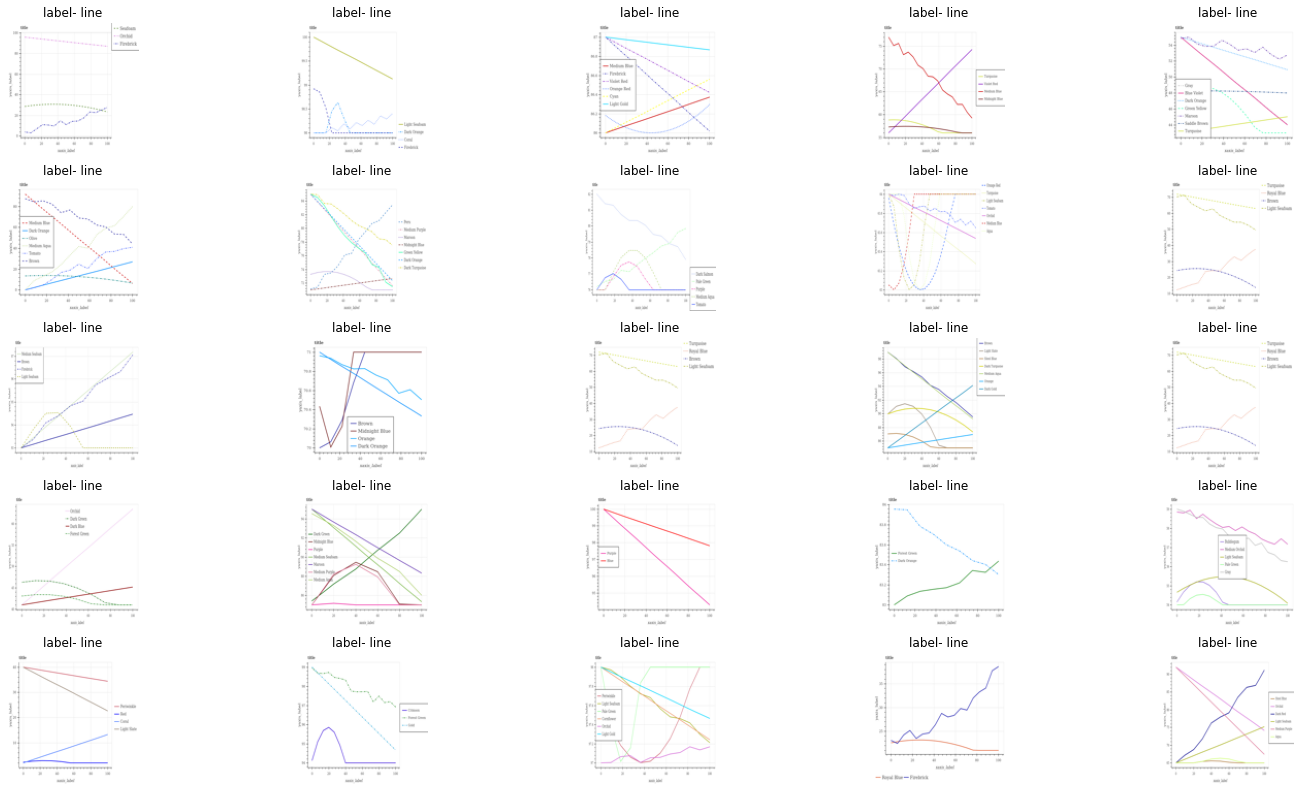

In [ ]:
import numpy as np
idxs = np.random.randint(0, 200,25)
fig, ax = plt.subplots(5, 5, figsize=(25,14))
idx = 0
for i in range(0, 5):
    for j in range(0, 5):

        ax[i][j].title.set_text('label- {}'.format(y_lines[idxs[idx]]))
        image = x_lines[idxs[idx]]
        ax[i][j].imshow(image)
        ax[i][j].axis("off")
        idx += 1 
plt.show()

random dot_line graphs are plotted

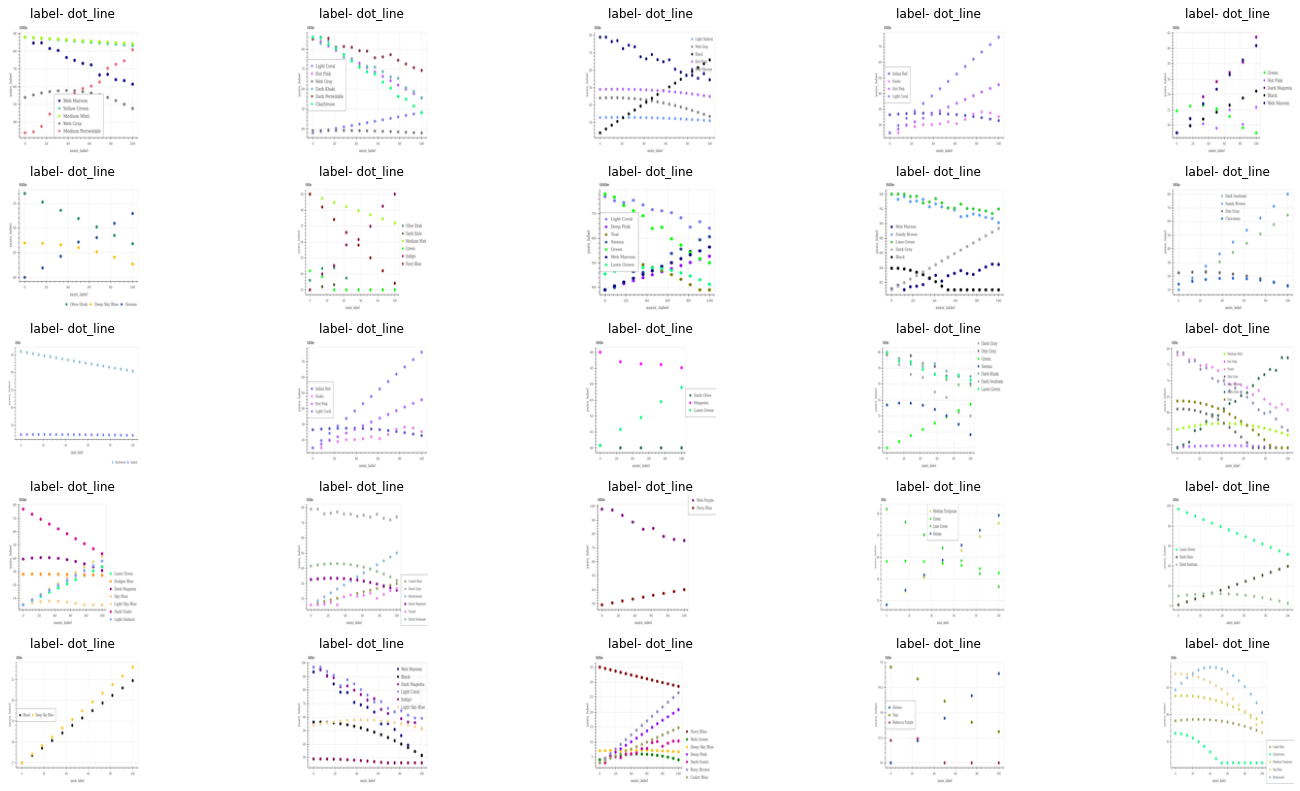

In [ ]:
x_dot_lines, y_dot_lines = read_data(train_dir, all_dot_lines, df2)

idxs = np.random.randint(0, 200,25)
fig, ax = plt.subplots(5, 5, figsize=(25,14))
idx = 0
for i in range(0, 5):
    for j in range(0, 5):

        ax[i][j].title.set_text('label- {0}'.format(y_dot_lines[idxs[idx]]))
        image = x_dot_lines[idxs[idx]]
        ax[i][j].imshow(image)
        ax[i][j].axis("off")
        idx += 1 
plt.savefig(os.path.join(dir_path,"images/cnn/train.png"), bbox_inches='tight')
plt.show()